## Problem Statement

You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. 

Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

#### Submitted By :-
Nitin Madhavan And Satish Kumar

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

import joblib

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# Implemented as Class Method on Agent Class

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    def __init__(self, state_size=None, action_size=None):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.005
        self.epsilon_min = 0.00001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        
        # create main model and target model
        self.model = self.build_model()
        
        # Q-values of tracked states self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_min = 0.00001
        self.states_tracked = []


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(200, input_dim = self.state_size,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(self.action_size,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        #print("Get Action state is ",state)
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # Give a random action only amongst possible action
            return random.sample(possible_actions_index,1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]
    

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))


    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                # Only take the max q_value from valid actions from next state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")

    def save(self, name):
        self.model.save(name)
        joblib.dump(self.model, name+'.pkl')
        
    def save_tracked_states(self, env):
        # Track state [0,0,0] and action (0,2) at index 2 in the action space.
        track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        # Use the model to predict the q_value of the state we are tracking.
        q_value = self.model.predict(track_state)
        # Get q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

In [7]:
Episodes = 10000

### DQN block

In [9]:
# Call the environment
env = CabDriver()

# Call the DQN agent
agent = DQNAgent(state_size = env.state_size, action_size = env.action_size)

rewards_per_episode, episodes = [], []

epsilons_per_episode = []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state))
    rides = 0
    
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state))
        # 4. Train the model byenv calling function agent.train_model
        agent.train_model(env)
        rides+= 1
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    
    epsilons_per_episode.append(agent.epsilon)
    
    # 5. Keep a track of rewards, Q-values, loss
    rewards_per_episode.append(score)   
    episodes.append(episode)

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,rides))
    # every few episodes:
    if (episode + 1) % 1 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        agent.save_tracked_states(env)
        
    if (episode + 1) % 1000 == 0:
        # save model weights
        print(f"Saving Model episode: {episode}")
        agent.save(name='saved_model')

Initial State is  [3, 22, 6]
episode 0, reward -330.0, memory_length 134, epsilon 0.99999, time 734.0, rides 133
Initial State is  [1, 0, 1]
episode 1, reward -425.0, memory_length 259, epsilon 0.9994901299779195, time 728.0, rides 124
Initial State is  [1, 22, 6]
episode 2, reward -378.0, memory_length 379, epsilon 0.9989905098283768, time 730.0, rides 119
Initial State is  [3, 19, 4]
episode 3, reward -441.0, memory_length 525, epsilon 0.9984911394264665, time 726.0, rides 145
Initial State is  [4, 21, 1]
episode 4, reward -316.0, memory_length 655, epsilon 0.9979920186473464, time 727.0, rides 129
Initial State is  [4, 14, 6]
episode 5, reward -229.0, memory_length 785, epsilon 0.9974931473662362, time 731.0, rides 129
Initial State is  [0, 2, 3]
episode 6, reward -197.0, memory_length 921, epsilon 0.996994525458418, time 726.0, rides 135
Initial State is  [3, 21, 0]
episode 7, reward -285.0, memory_length 1064, epsilon 0.9964961527992363, time 725.0, rides 142
Initial State is  [4,

episode 66, reward -149.0, memory_length 2000, epsilon 0.9675288842034362, time 736.0, rides 130
Initial State is  [1, 19, 5]
episode 67, reward -224.0, memory_length 2000, epsilon 0.9670452406822906, time 724.0, rides 121
Initial State is  [1, 11, 5]
episode 68, reward -279.0, memory_length 2000, epsilon 0.9665618389224603, time 722.0, rides 130
Initial State is  [3, 16, 0]
episode 69, reward -189.0, memory_length 2000, epsilon 0.9660786788030947, time 733.0, rides 134
Initial State is  [0, 19, 0]
episode 70, reward -193.0, memory_length 2000, epsilon 0.965595760203404, time 728.0, rides 112
Initial State is  [4, 4, 3]
episode 71, reward -397.0, memory_length 2000, epsilon 0.9651130830026582, time 726.0, rides 105
Initial State is  [3, 6, 1]
episode 72, reward -394.0, memory_length 2000, epsilon 0.9646306470801883, time 728.0, rides 135
Initial State is  [0, 5, 3]
episode 73, reward -356.0, memory_length 2000, epsilon 0.964148452315385, time 726.0, rides 132
Initial State is  [3, 9, 2

### Plot the Q-Values for Tracked State-Action pairs

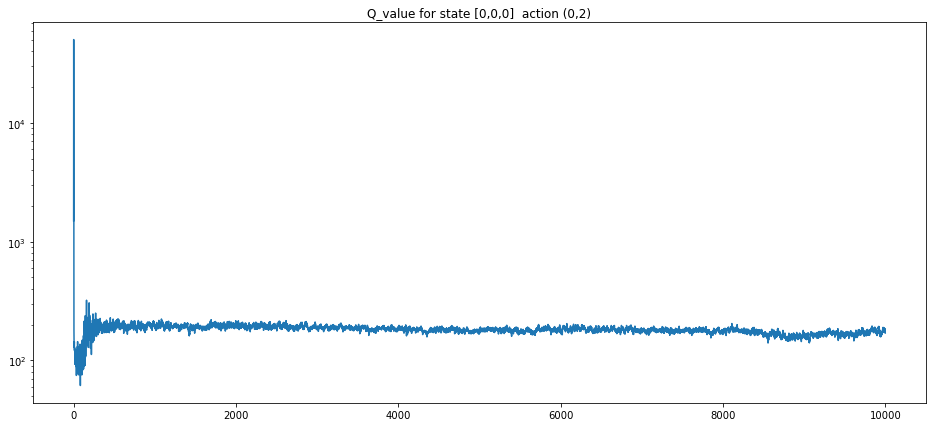

In [20]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

### Track Convergence of rewards per Episode

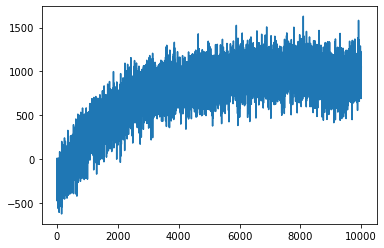

In [21]:
plt.plot(episodes,rewards_per_episode)
plt.show()

### Epsilon-decay sample function

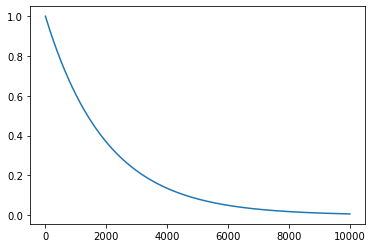

In [22]:
plt.plot(episodes, epsilons_per_episode)
plt.show()